In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
pd.options.display.float_format = '{:,.0f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import dataframe_image as dfi
from pandas.api.types import CategoricalDtype
from matplotlib.ticker import MultipleLocator, FuncFormatter
from scipy.stats import linregress
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [3]:
Results = pd.read_csv('Accepted_Only_Predicted_vs_Actual_Round1.csv')

In [4]:
Results.shape

(254762, 13)

In [5]:
Results['Pred_Prob'] = Results['Pred_Prob'] * 100

In [6]:
Results.head()

,Term,FICO_Score,Employment_Length,Debt-Income,Loan-Income,Int_Rate,Mortgage_Accounts,Bankruptcies,Home_Ownership,Loan_Purpose,Pred_Prob,Pred_Label,Actual_Label
0,0,662,0,10,17,21,0,0,RENT,debt_consolidation,33,0,1
1,1,702,10,31,19,9,4,0,MORTGAGE,credit_card,49,0,1
2,1,682,9,32,36,27,2,0,MORTGAGE,debt_consolidation,18,0,0
3,0,687,2,33,10,13,0,0,RENT,debt_consolidation,45,0,1
4,0,692,3,17,19,11,6,0,MORTGAGE,credit_card,74,0,1


In [71]:
def Prob_scatter_plot_reg(x_col, xformat='number', rot=0, df=Results, trim_max=None, trim_min=None, dpi=100):
    col2 = 'Pred_Prob'
    col2_color = 'blue'
    df = df.copy()

    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 6), dpi=dpi)
    plt.scatter(df[x_col], df[col2], s=30, color=col2_color, alpha=0.5, label='Pred_Prob')

    #Regression line
    if pd.api.types.is_numeric_dtype(df[x_col]):
        slope, intercept, r, p, _ = linregress(df[x_col], df[col2])
        x_vals = np.linspace(df[x_col].min(), df[x_col].max(), 200)
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, linestyle='--', color=col2_color,
                 label=f'Pred_Prob (R²={r**2:.2f})')

    #Line at 75% threshhold
    plt.axhline(75, color='red', linestyle='--', linewidth=1.5, label='75% Threshold')

    plt.title(f'Predicted Probability by {x_col}', fontsize=18, pad=15)
    plt.xlabel(x_col, fontsize=15)
    plt.ylabel('Value (%)', fontsize=15)
    plt.xticks(rotation=rot, ha='right')
    plt.legend(title='', fontsize=10, loc='best')

    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))
    if xformat == 'percent' and pd.api.types.is_numeric_dtype(df[x_col]):
        plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))
    elif xformat == 'number' and pd.api.types.is_numeric_dtype(df[x_col]):
        plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    plt.ylim(bottom=0, top=100)
    plt.xlim(left=trim_min, right=trim_max)
        
    plt.tight_layout()
    plt.show()

In [62]:
def Prob_scatter_plot_cat(x_col, df=Results, rot=45, dpi=100):
    col2 = 'Pred_Prob'
    col2_color = 'blue'
    df = df.copy()
    
    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 6), dpi=dpi)

    #Categories to integers
    categories = df[x_col].astype(str).unique()
    categories.sort()
    cat_map = {cat: i for i, cat in enumerate(categories)}
    x_vals = df[x_col].astype(str).map(cat_map)

    #Jitter Scatter
    jitter = 0.15
    x_jitter = x_vals + np.random.uniform(-jitter, jitter, size=len(df))
    plt.scatter(x_jitter, df[col2], s=30, color=col2_color, alpha=0.6, label='Pred_Prob')

    #Mean per category (line) 
    means = df.groupby(x_col)[col2].mean()
    mean_positions = [cat_map[cat] for cat in means.index]
    plt.plot(mean_positions, means.values, linestyle='--', color='purple', marker='o', label='Mean Pred_Prob')

    #75% threshold line
    plt.axhline(75, color='red', linestyle='--', linewidth=1.5, label='75% Threshold')

    plt.title(f'Predicted Probability by {x_col}', fontsize=18, pad=15)
    plt.xlabel(x_col, fontsize=15)
    plt.ylabel('Predicted Probability (%)', fontsize=15)
    plt.xticks(ticks=list(cat_map.values()), labels=list(cat_map.keys()), rotation=rot, ha='right')
    plt.ylim(bottom=0, top=100)
    plt.legend(title='', fontsize=10, loc='best')
    plt.tight_layout()
    plt.show()

In [66]:
def stacked_density_with_stats_boxes(col, df=Results, xformat='number', pos_side='left', trim_max=None, trim_min=None, dpi=100, box_y_frac=1, edge_padding_frac=0.02):
    sns.set_style('whitegrid')
    plt.figure(figsize=(12,6), dpi=dpi)

    #Stats (full data)
    full_data = df[df[col].notna() & (df[col] >= 0)]
    label_map = {1: 'Predicted_Safe', 0: 'Predicted_Risky'}
    color_map = {1: 'green', 0: "red"}

    full_stats = {}
    for app in (1, 0):
        subset = full_data[full_data['Pred_Label'] == app]
        mode_val = subset[col].mode()
        mode_val = mode_val.iloc[0] if not mode_val.empty else np.nan
        full_stats[app] = {
            'label': label_map[app],
            'color': color_map[app],
            'mean': subset[col].mean(),
            'mode': mode_val,
            'min': subset[col].min(),
            'max': subset[col].max(),
            'count': subset.shape[0]
        }

    #Trimmed Plot Data
    plot_data = full_data.copy()
    if trim_max is not None:
        plot_data = plot_data[plot_data[col] <= trim_max]
    if trim_min is not None:
        plot_data = plot_data[plot_data[col] >= trim_min]

    ax = plt.gca()
    plotted = False

    #KDEs
    for app in (1, 0):
        subset = plot_data[plot_data['Pred_Label'] == app]
        if subset.empty:
            continue
        if subset[col].nunique() == 1:
            val = float(subset[col].iloc[0])
            xs = np.linspace(val - 1e-6, val + 1e-6, 2)
            ax.fill_between(xs, 0, [0.01, 0.01], color=color_map[app], alpha=0.6, label=label_map[app])
            ax.plot(xs, [0.01, 0.01], color=color_map[app])
        else:
            sns.kdeplot(data=subset, x=col, fill=True, color=color_map[app], alpha=0.6, label=label_map[app])
        plotted = True

    if not plotted:
        raise ValueError('No KDEs plotted; both Pred_Label groups empty')

    #Vertical lines
    for app in (1, 0):
        subset = plot_data[plot_data['Pred_Label'] == app]
        if subset.empty:
            continue
        mean_val = subset[col].mean()
        min_val = subset[col].min()
        max_val = subset[col].max()
        ax.axvline(min_val, color=color_map[app], linestyle=':', linewidth=1.5)
        ax.axvline(mean_val, color=color_map[app], linestyle='--', linewidth=2)
        ax.axvline(max_val, color=color_map[app], linestyle=':', linewidth=1.5)

    #Text box positions
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ypos = ymin + box_y_frac * (ymax - ymin)
    x_offset = max((xmax - xmin) * edge_padding_frac, 1.0)
    if pos_side == 'left':
        positions = {
            'Predicted_Safe': {'xpos': xmin + x_offset, 'ha': 'left'},
            'Predicted_Risky': {'xpos': xmax - x_offset, 'ha': 'right'}
        }
    else:
        positions = {
            'Predicted_Safe': {'xpos': xmax - x_offset, 'ha': 'right'},
            'Predicted_Risky': {'xpos': xmin + x_offset, 'ha': 'left'}
        }

    #Text boxes with full data stats
    for app in (1, 0):
        s = full_stats[app]
        pos = positions[s['label']]
        txt = (f"{s['label']}\n"
               f"Mean: {s['mean']:.2f}\n"
               f"Mode: {s['mode']:.2f}\n"
               f"Min: {s['min']:.2f}\n"
               f"Max: {s['max']:.2f}\n"
               f"Count: {s['count']:,}")
        ax.text(pos['xpos'], ypos, txt, color=s['color'], va='top', ha=pos['ha'],
                fontsize=11, fontweight='bold', bbox=dict(facecolor='white', alpha=0.85, edgecolor=s['color']))

    #Set xlim according to trim_min/trim_max
    if trim_min is not None or trim_max is not None:
        left = trim_min if trim_min is not None else xmin
        right = trim_max if trim_max is not None else xmax
        ax.set_xlim(left, right)

    plt.title(f'Layered Density of {col} by Prediction', fontsize=18, pad=12)
    plt.ylabel("Density", fontsize=13)
    plt.xlabel(col, fontsize=13)
    if xformat == 'percent':
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))
    else:
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.legend()
    plt.tight_layout()
    plt.show()

In [67]:
def stacked_hist_acceptance(col, df=Results, xformat='number', pos_side='left', trim_max=None, trim_min=None, bins=100, alpha=0.6, dpi=100):
    sns.set_style('whitegrid')
    plt.figure(figsize=(12,6), dpi=dpi)
    
    df = df.copy()

    #Stats (full data)
    true_stats = {}
    for app in [1, 0]:
        subset = df[df['Pred_Label'] == app]
        mode_val = subset[col].mode()
        mode_val = mode_val.iloc[0] if not mode_val.empty else np.nan
        true_stats[app] = {
            'label': 'Predicted_Safe' if app==1 else 'Predicted_Risky',
            'color': "green" if app==1 else "red",
            'mean': subset[col].mean(),
            'mode': mode_val,
            'min': subset[col].min(),
            'max': subset[col].max(),
            'count': subset[col].shape[0]
        }

    #Plot Range
    plot_df = df.copy()
    if trim_max is not None:
        plot_df[col] = plot_df[col].clip(upper=trim_max)
    if trim_min is not None:
        plot_df[col] = plot_df[col].clip(lower=trim_min)

    #Histogram
    sns.histplot(
        data=plot_df,
        x=col,
        hue='Pred_Label',
        multiple='layer',
        bins=bins,
        palette={1: 'green', 0: 'red'},
        alpha=alpha,
        edgecolor=None,
        legend=False
    )

    ax = plt.gca()
    ymax = ax.get_ylim()[1]
    xmin, xmax = ax.get_xlim()
    offset = (xmax - xmin) * 0.02  # 2% padding

    #Text box positions
    if pos_side == 'left':
        positions = {
            "Predicted_Safe":  {'xpos': xmin + offset, 'ha': 'left'},
            "Predicted_Risky": {'xpos': xmax - offset, 'ha': 'right'}
        }
    else:
        positions = {
            "Predicted_Safe":  {'xpos': xmax - offset, 'ha': 'right'},
            "Predicted_Risky": {'xpos': xmin + offset, 'ha': 'left'}
        }

    #Text boxes full data stats
    for s in true_stats.values():
        pos = positions[s['label']]
        mean_s = f"{s['mean']:.2f}" if not np.isnan(s['mean']) else "NA"
        mode_s = f"{s['mode']:.2f}" if not np.isnan(s['mode']) else "NA"
        min_s = f"{s['min']:.2f}" if not np.isnan(s['min']) else "NA"
        max_s = f"{s['max']:.2f}" if not np.isnan(s['max']) else "NA"
        count_s = f"{s['count']:,}"
        plt.text(
            pos['xpos'], ymax * 1.0,
            f"{s['label']}\nMean: {mean_s}\nMode: {mode_s}\nMin: {min_s}\nMax: {max_s}\nCount: {count_s}",
            color=s['color'],
            fontsize=11,
            fontweight='bold',
            ha=pos['ha'],
            va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor=s['color'])
        )

    plt.title(f'Histogram of {col} by Prediction', fontsize=18, pad=20)
    plt.xlabel(col, fontsize=15)
    plt.ylabel('Count', fontsize=15)
    if xformat == 'percent':
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))
    else:
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.tight_layout()
    plt.show()

In [68]:
def side_by_side_barplot(
    col, df=Results, normalize=False, dpi=100):

    #Filter valid rows
    data = df[df[col].notna()]
    label_map = {1: 'Predicted_Safe', 0: 'Predicted_Risky'}
    color_map = {1: "green", 0: "red"}
    counts = data.groupby([col, 'Pred_Label']).size().unstack(fill_value=0)
    counts = counts.reindex(columns=[1,0], fill_value=0)

    if normalize:
        counts = counts.div(counts.sum(axis=1), axis=0) * 100
        ylabel = 'Percentage'
    else:
        ylabel = 'Count'

    sns.set_style('whitegrid')
    plt.figure(figsize=(12,6), dpi=dpi)
    ax = counts.plot(kind='bar', color=[color_map[1], color_map[0]], width=0.7)

    plt.title(f'Side-by-Side Bar Plot of {col} by Prediction', fontsize=18, pad=12)
    plt.xlabel(col, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

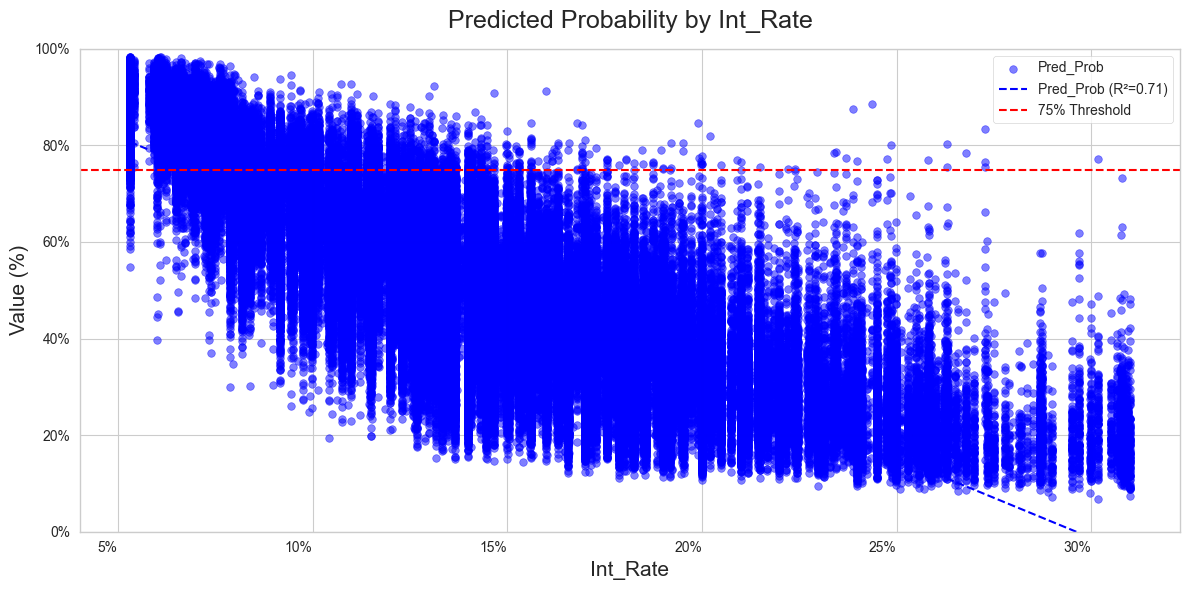

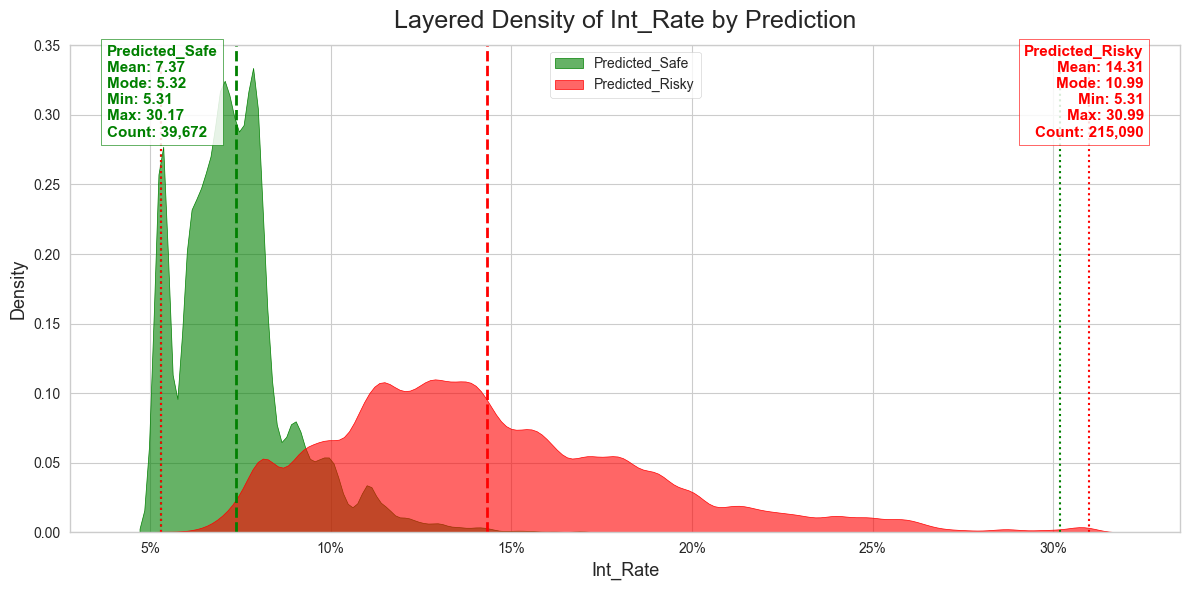

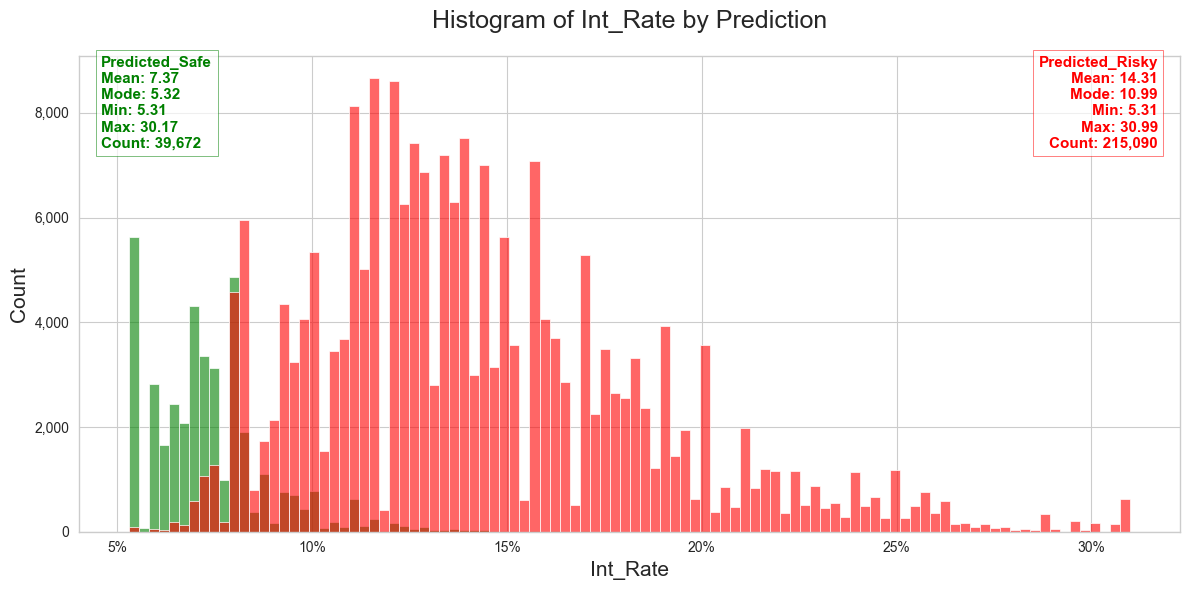

In [69]:
Prob_scatter_plot_reg('Int_Rate', xformat='percent')
stacked_density_with_stats_boxes('Int_Rate', xformat='percent')
stacked_hist_acceptance('Int_Rate', xformat='percent')

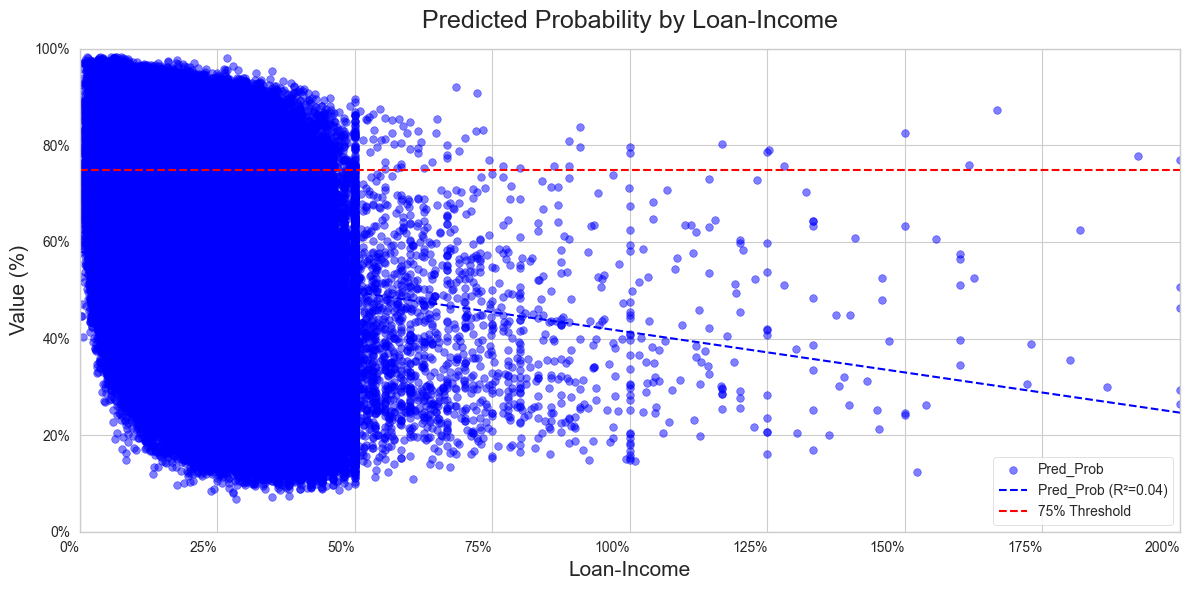

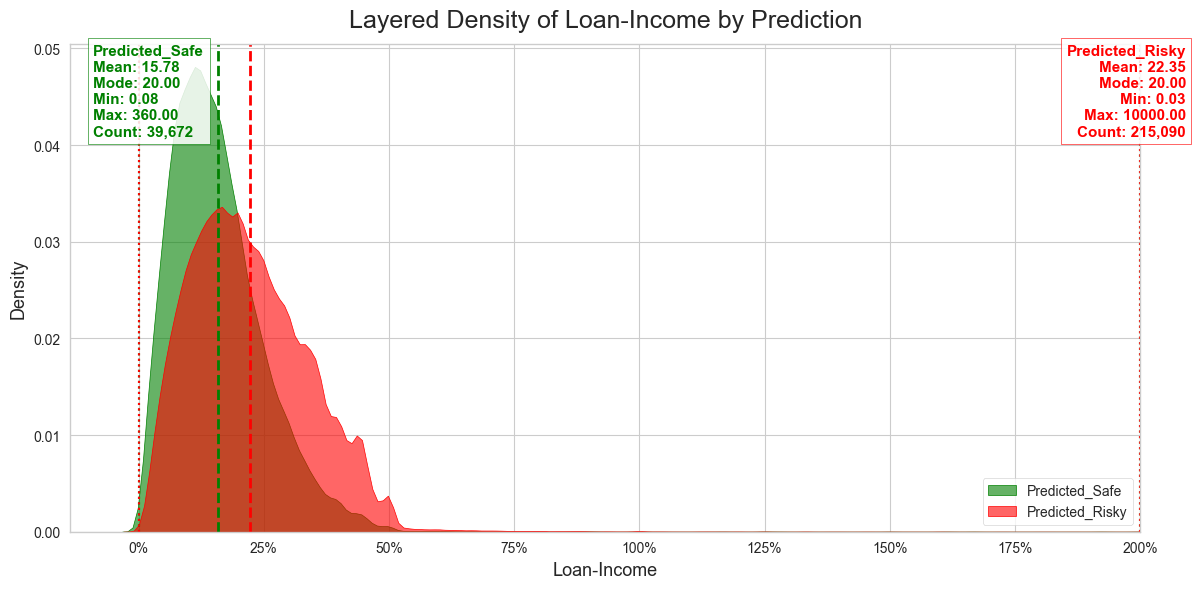

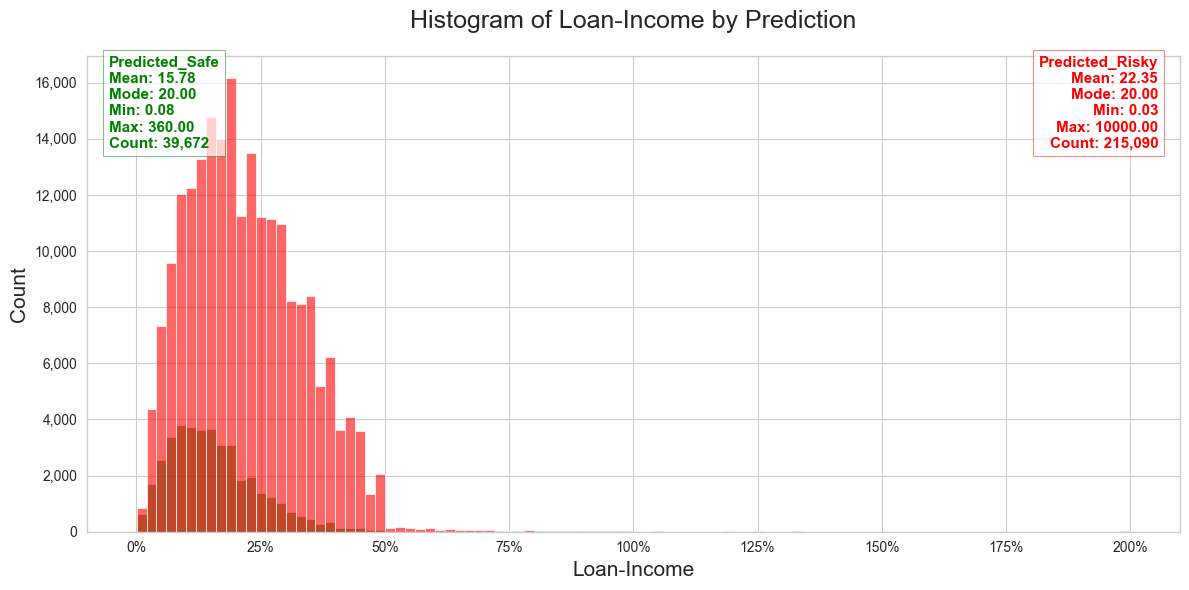

In [73]:
Prob_scatter_plot_reg('Loan-Income', xformat='percent', trim_min=0, trim_max=200)
stacked_density_with_stats_boxes('Loan-Income', xformat='percent', trim_max=200)
stacked_hist_acceptance('Loan-Income', xformat='percent', trim_max=200)

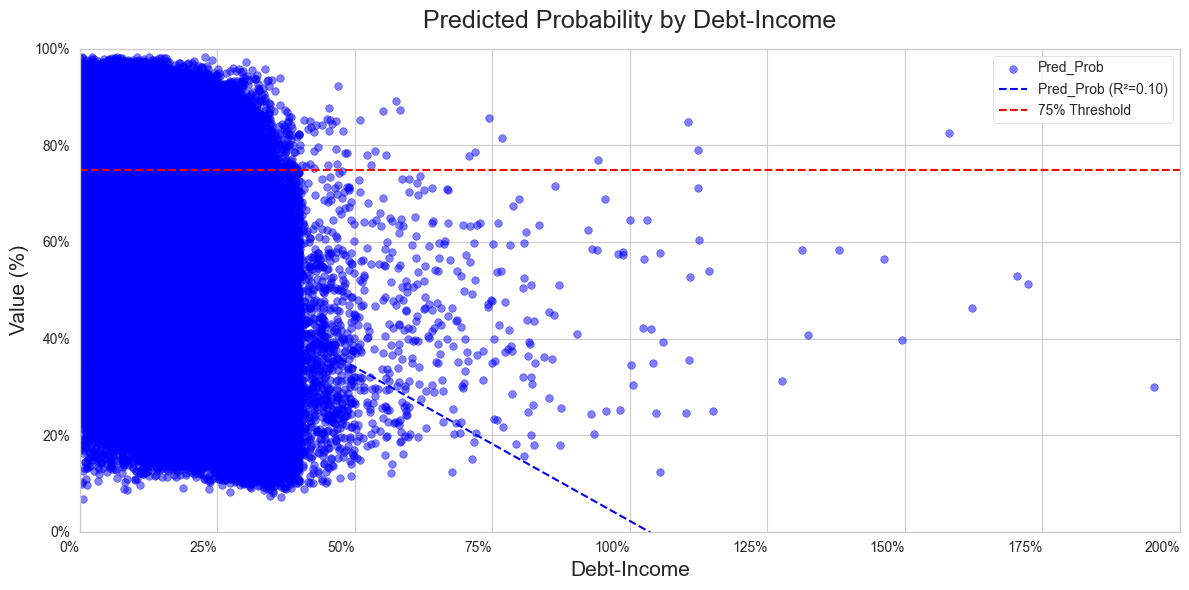

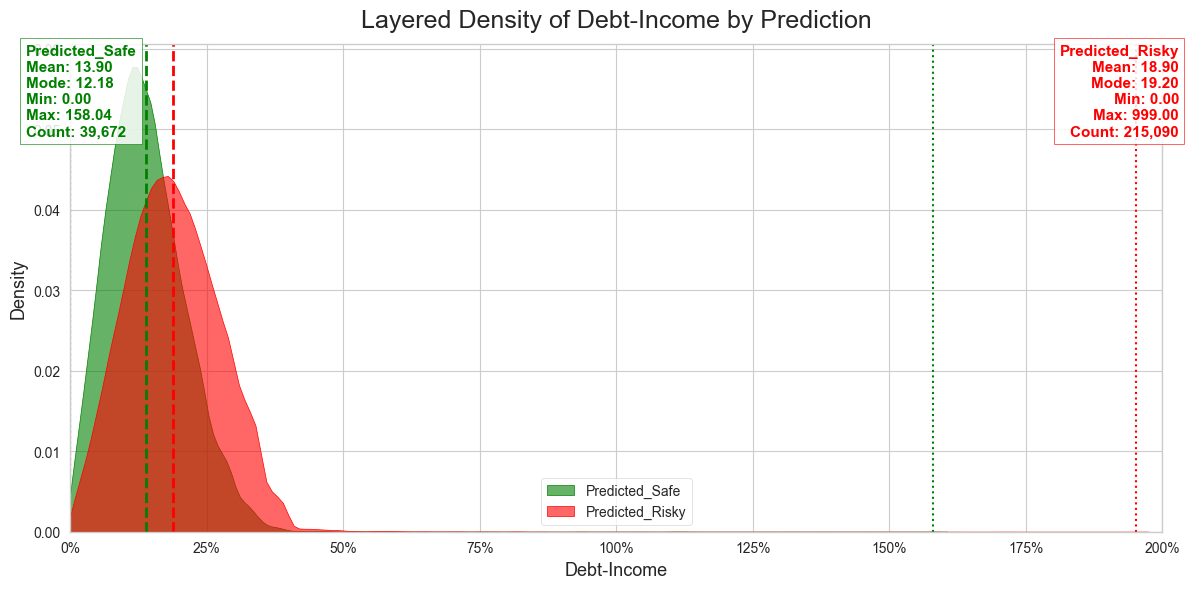

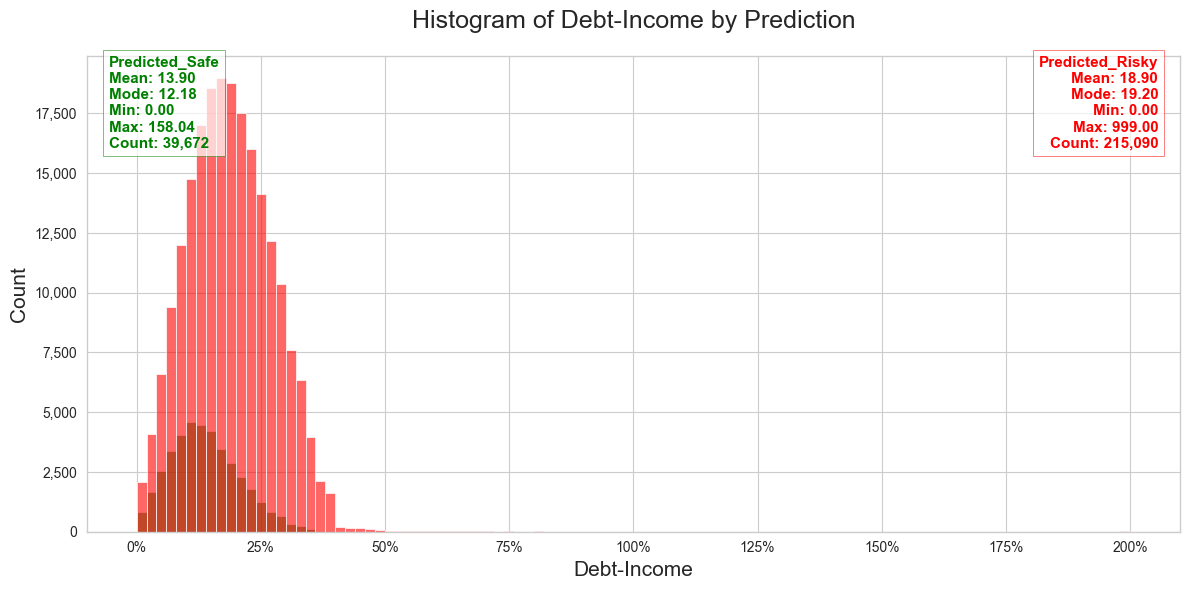

In [43]:
Prob_scatter_plot_reg('Debt-Income', xformat='percent', trim_max=200)
stacked_density_with_stats_boxes('Debt-Income', xformat='percent', trim_max=200)
stacked_hist_acceptance('Debt-Income', xformat='percent', trim_max=200)

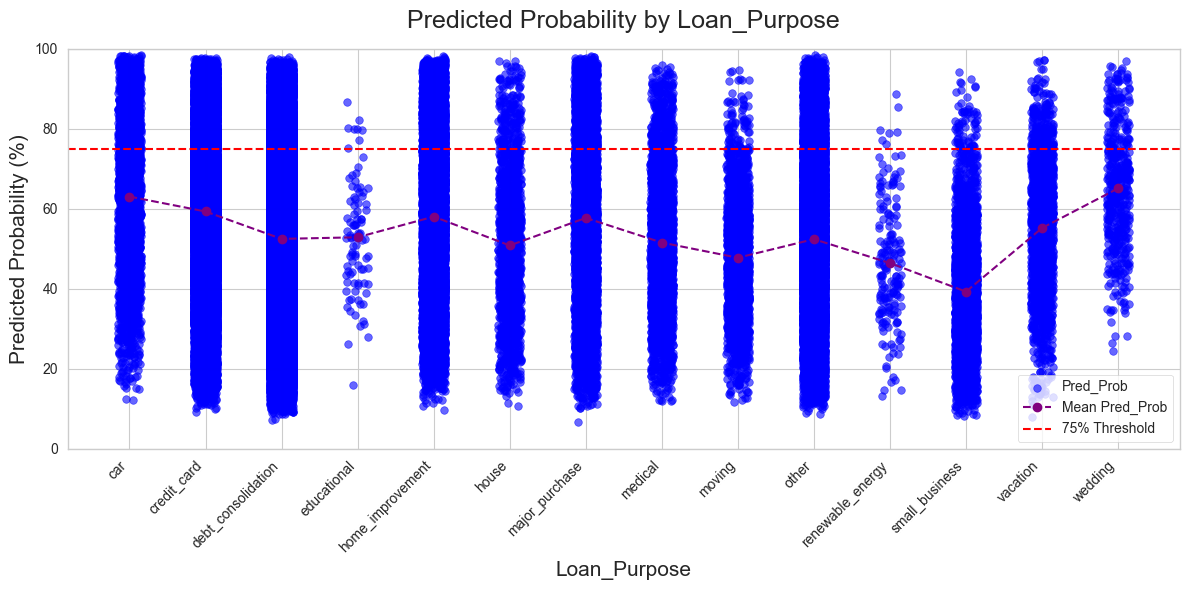

<Figure size 1200x600 with 0 Axes>

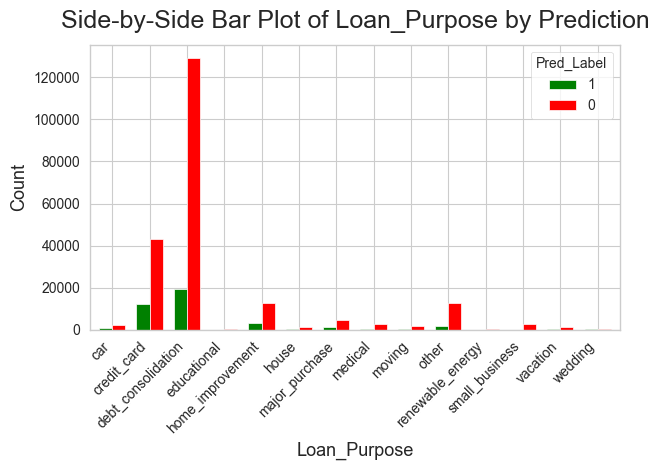

In [48]:
Prob_scatter_plot_cat('Loan_Purpose')
side_by_side_barplot('Loan_Purpose')

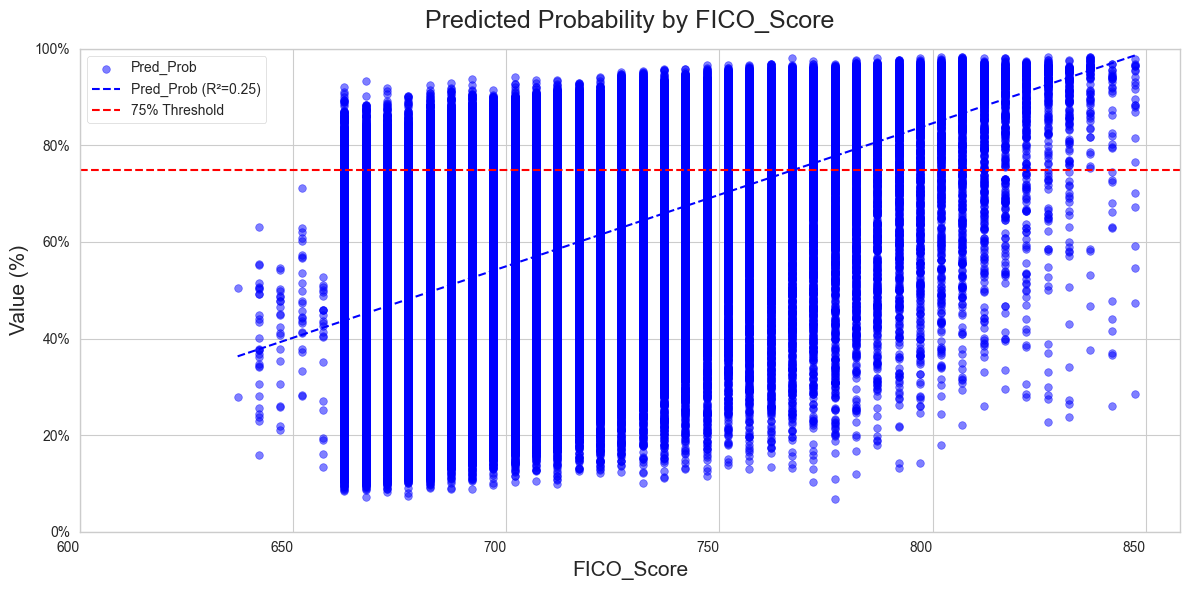

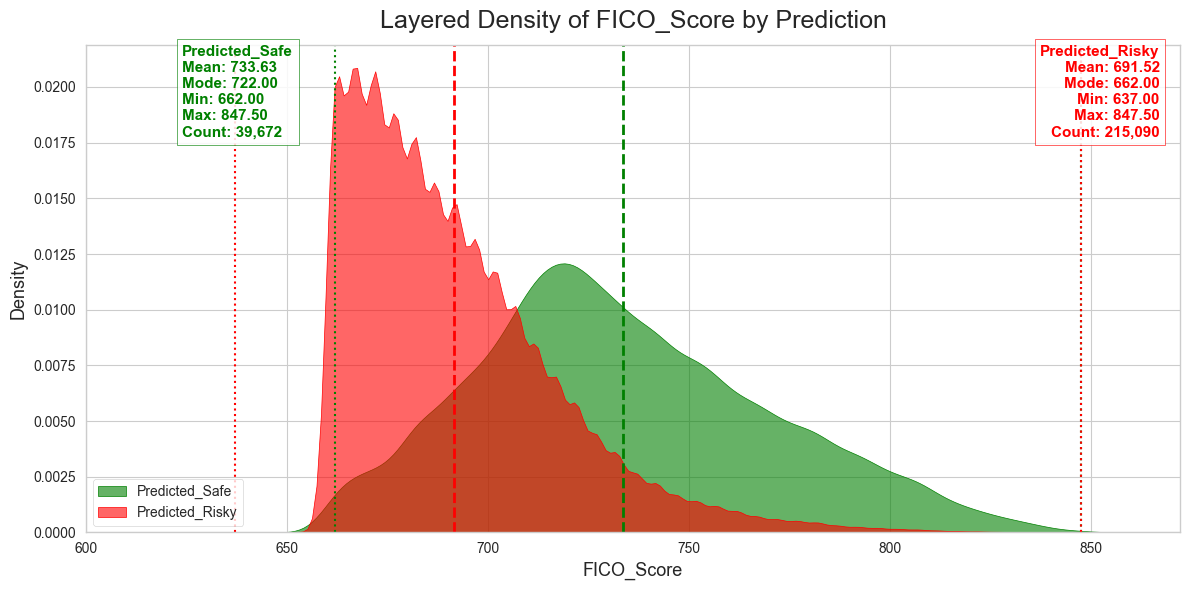

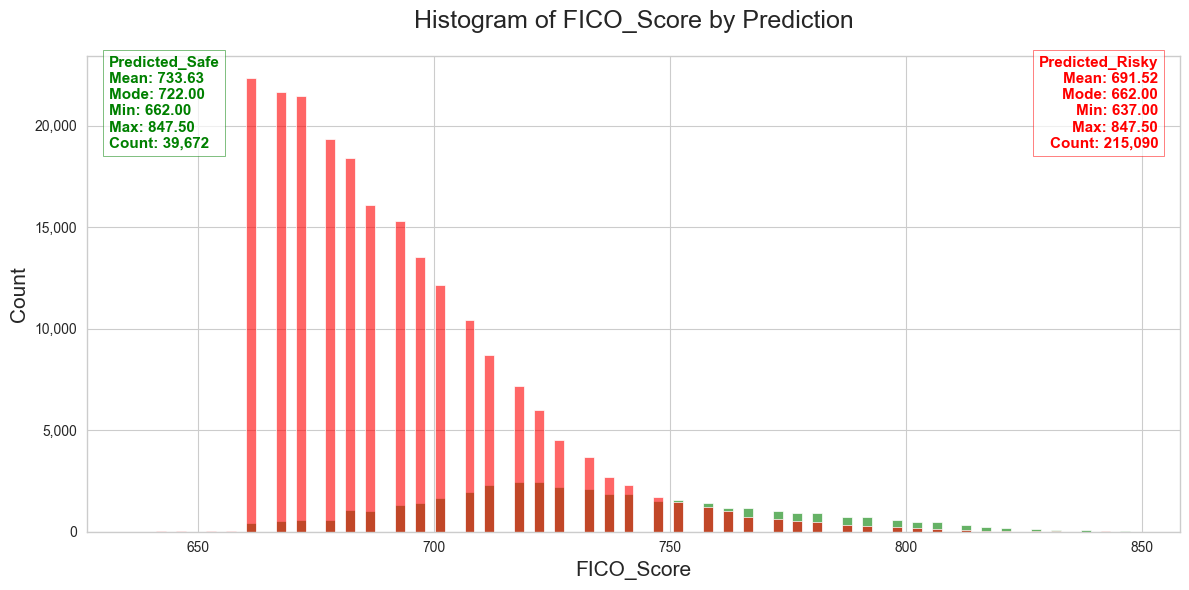

In [74]:
Prob_scatter_plot_reg('FICO_Score', xformat='number', trim_min=600)
stacked_density_with_stats_boxes('FICO_Score', xformat='number', trim_min=600)
stacked_hist_acceptance('FICO_Score', xformat='number', trim_min=600)

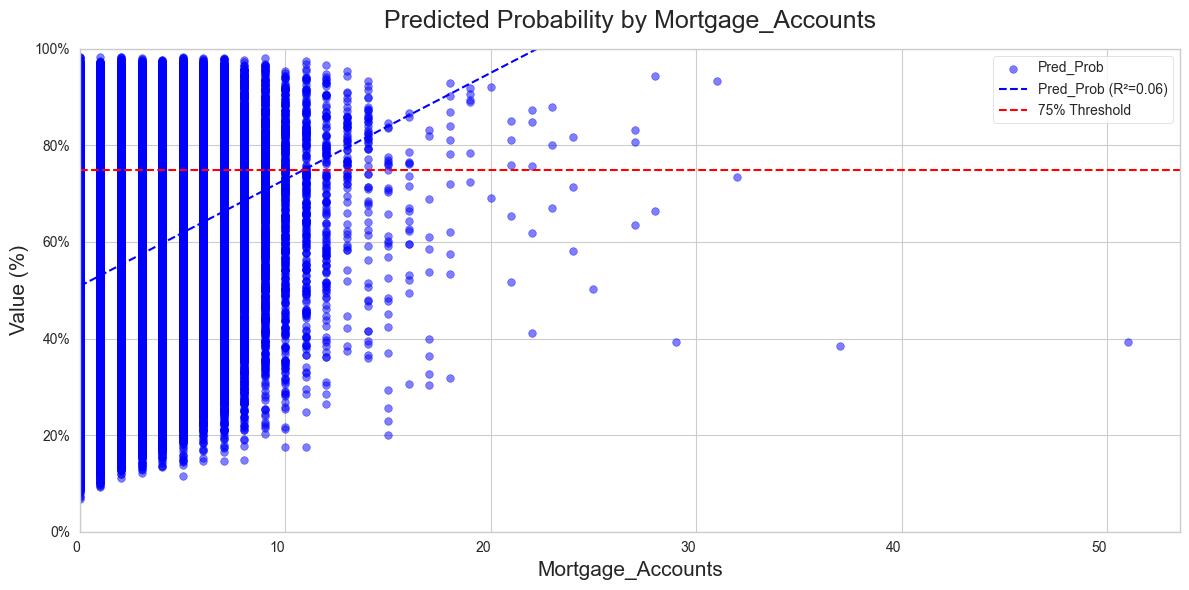

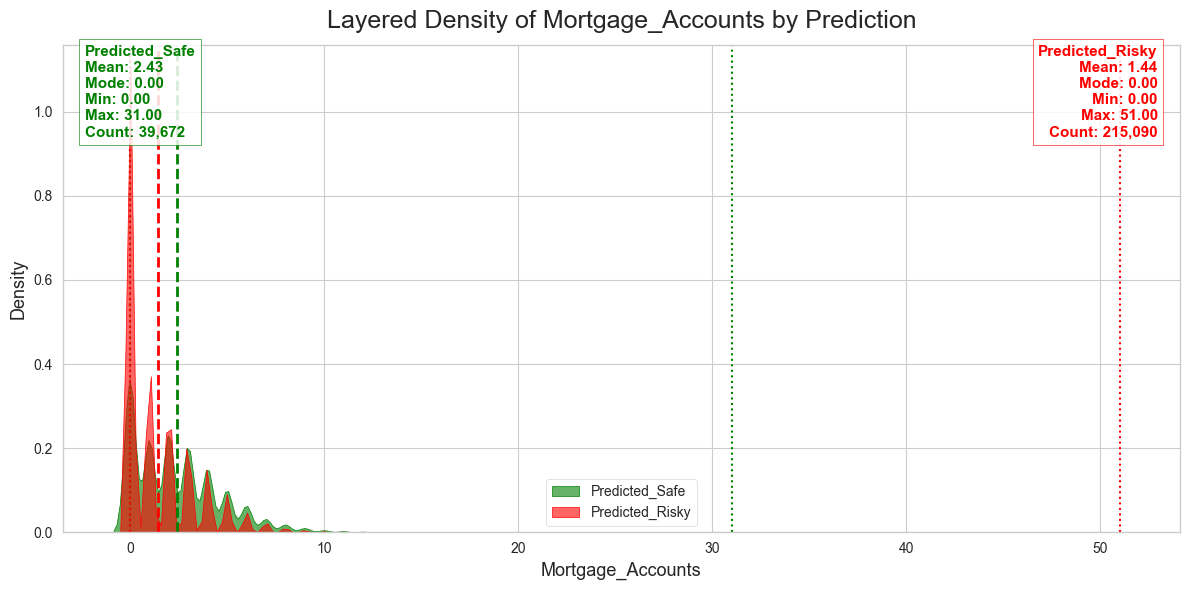

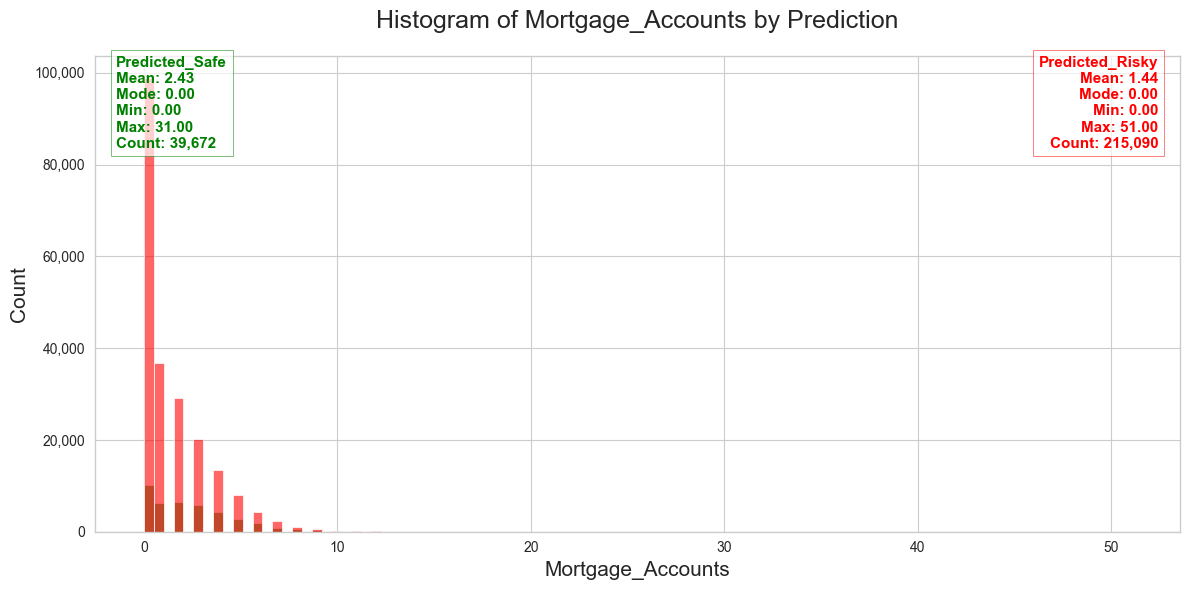

In [75]:
Prob_scatter_plot_reg('Mortgage_Accounts', xformat='number')
stacked_density_with_stats_boxes('Mortgage_Accounts', xformat='number')
stacked_hist_acceptance('Mortgage_Accounts', xformat='number')

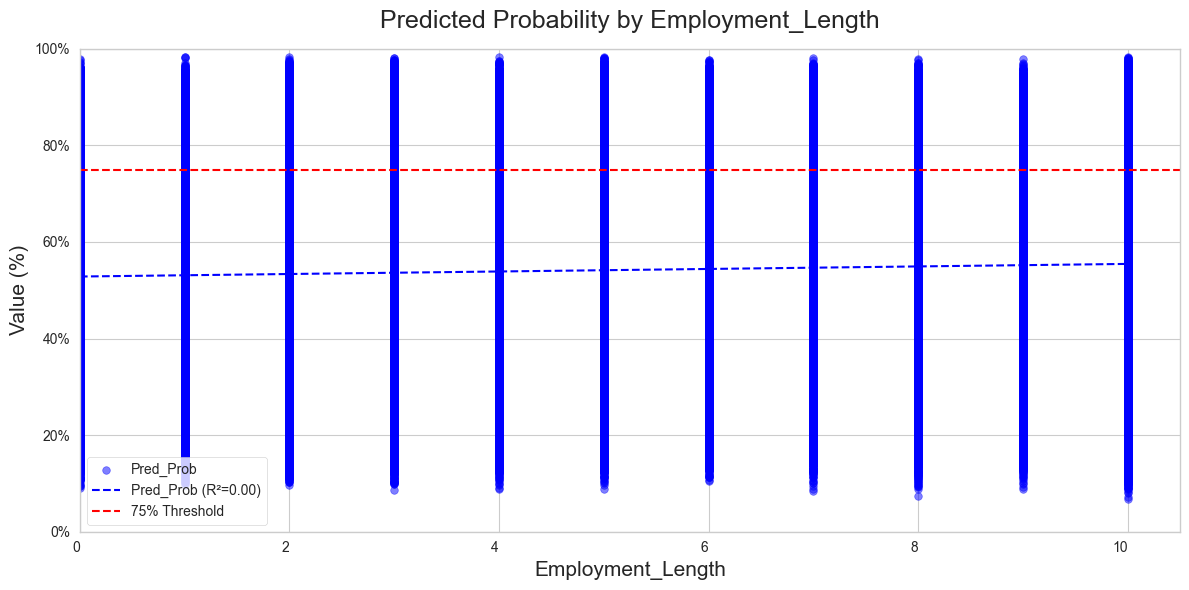

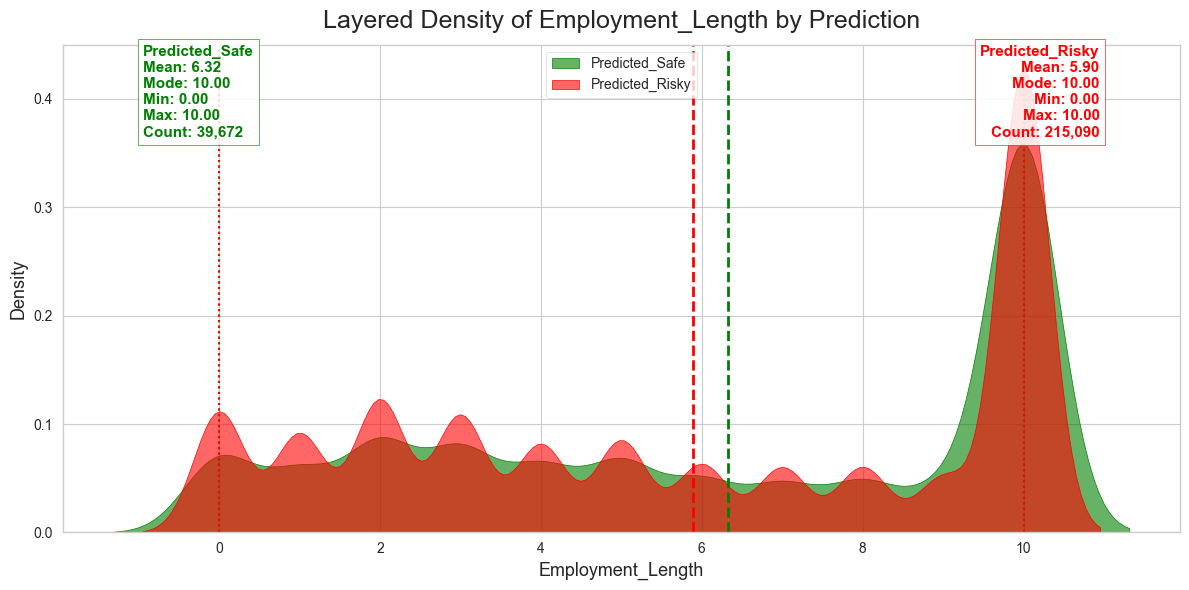

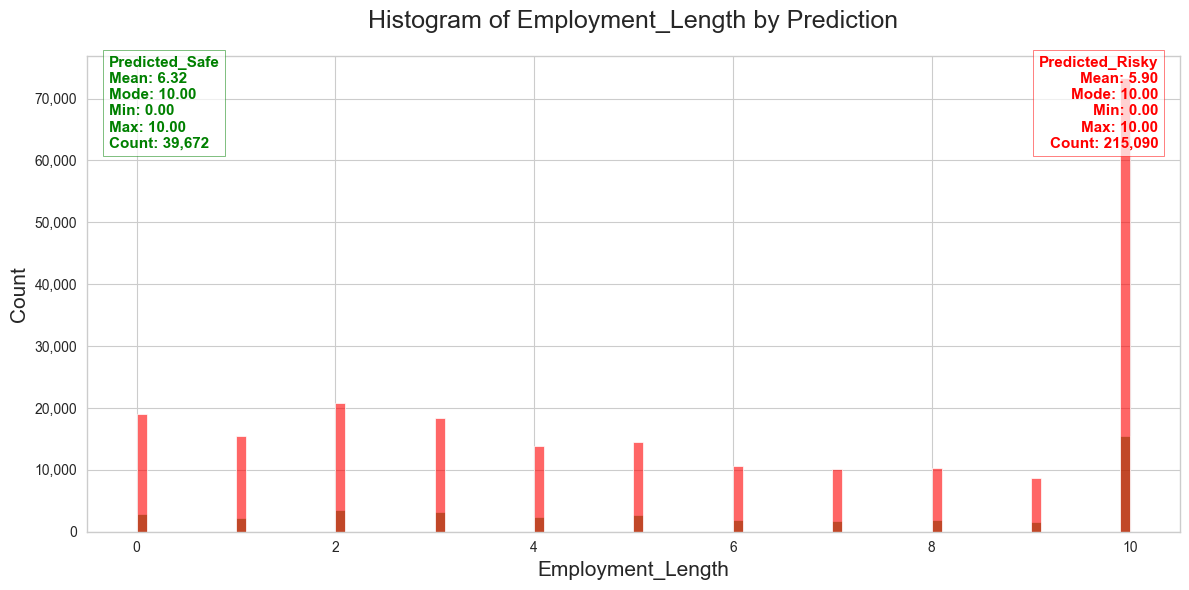

In [76]:
Prob_scatter_plot_reg('Employment_Length', xformat='number')
stacked_density_with_stats_boxes('Employment_Length', xformat='number')
stacked_hist_acceptance('Employment_Length', xformat='number')

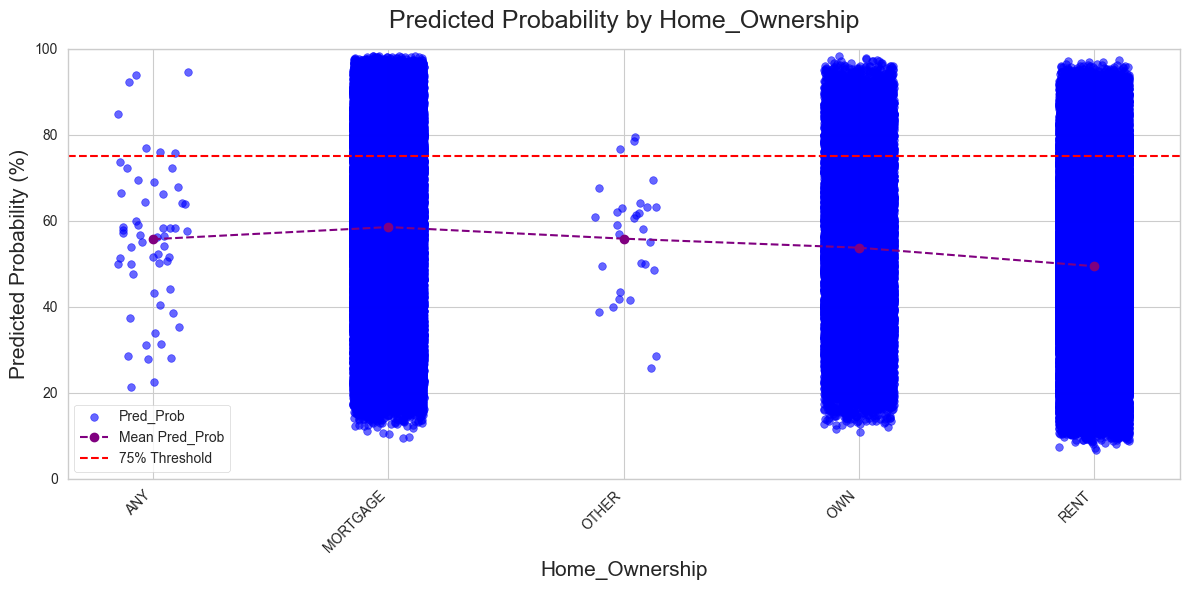

<Figure size 1200x600 with 0 Axes>

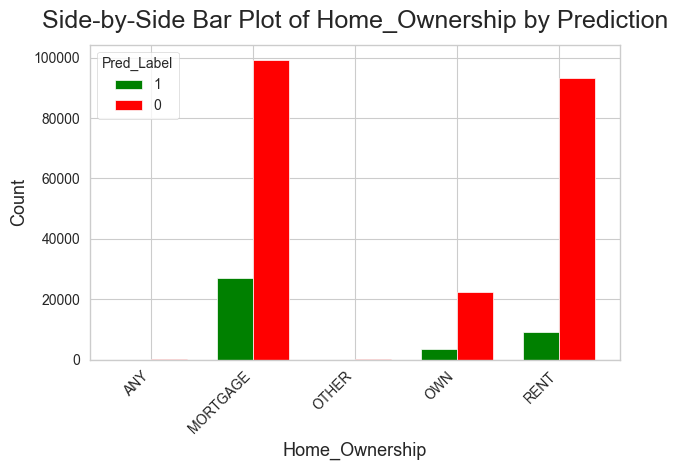

In [77]:
Prob_scatter_plot_cat('Home_Ownership')
side_by_side_barplot('Home_Ownership')

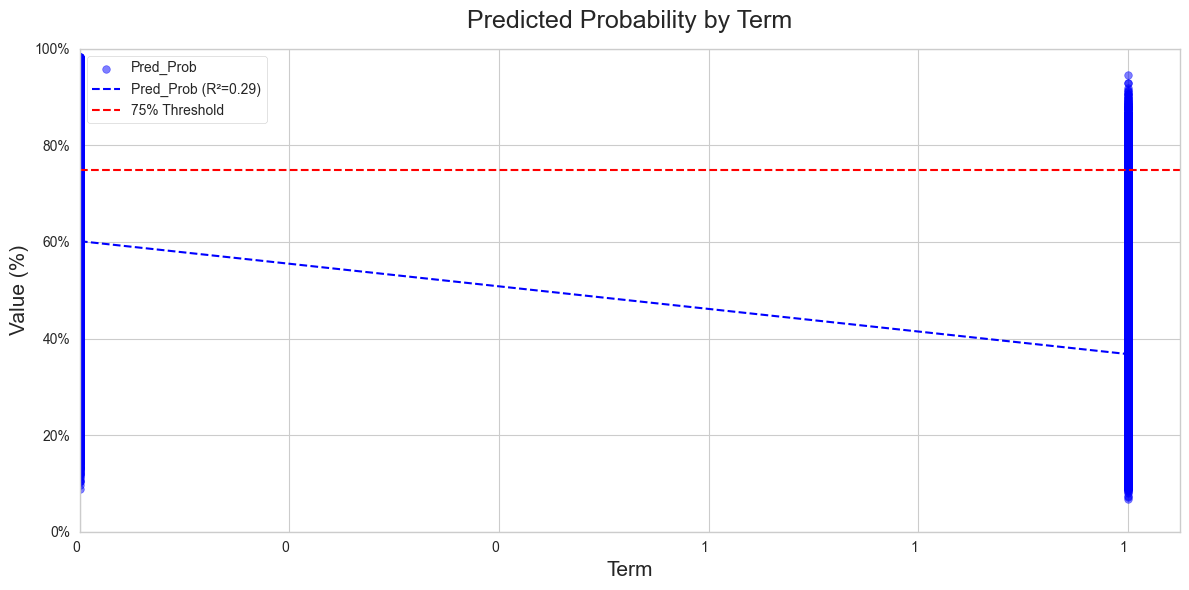

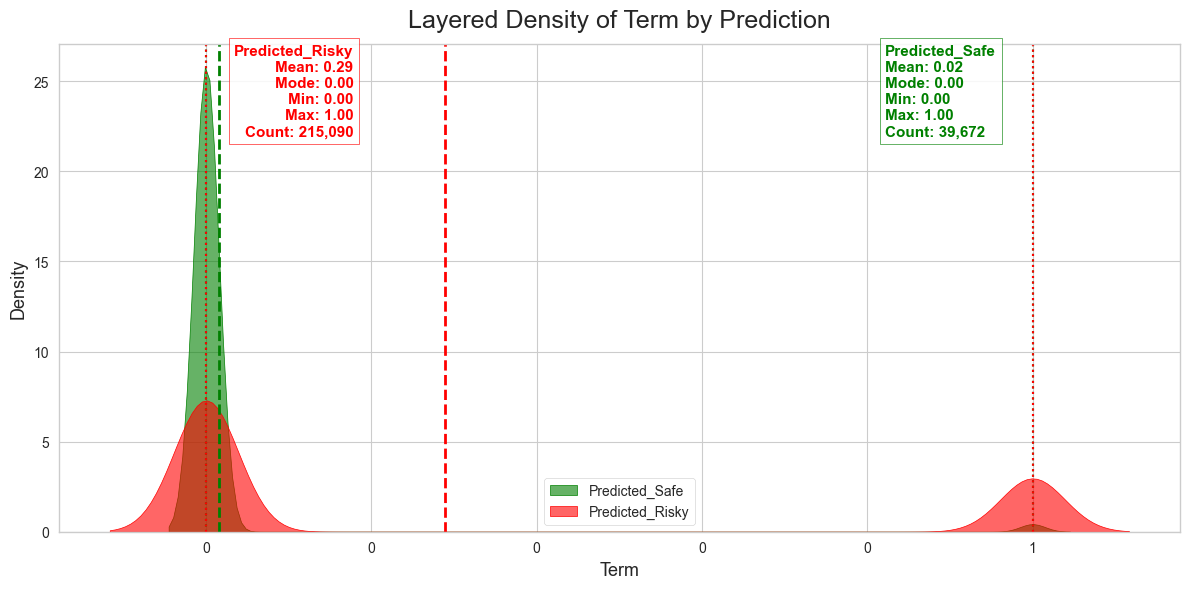

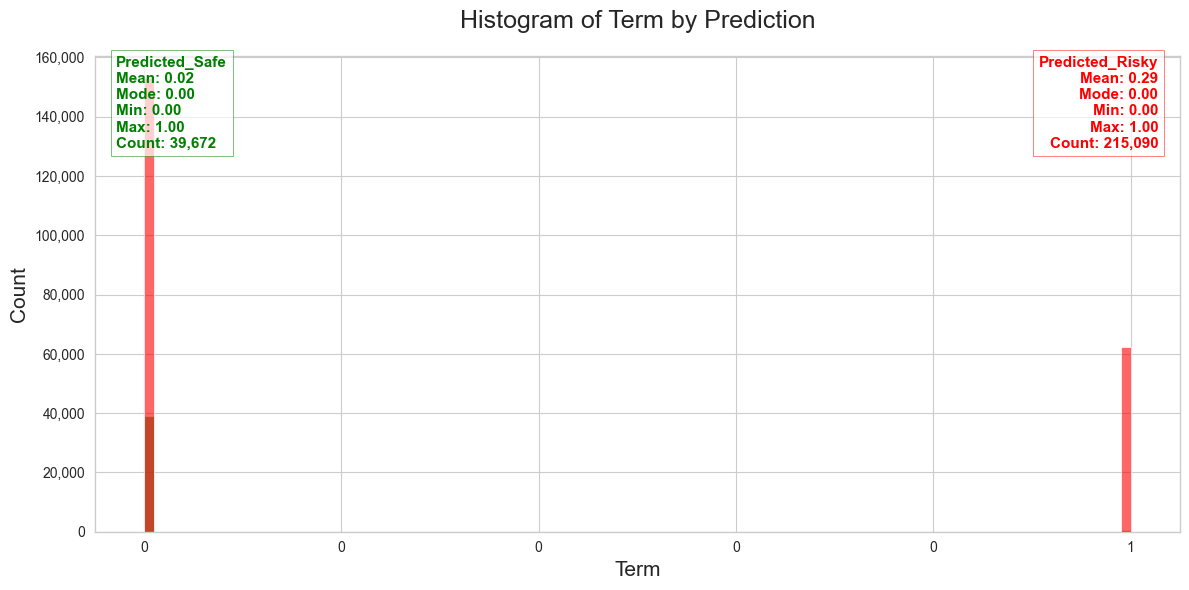

In [78]:
Prob_scatter_plot_reg('Term', xformat='number', trim_max=None)
stacked_density_with_stats_boxes('Term', xformat='number', trim_max=None)
stacked_hist_acceptance('Term', xformat='number', trim_max=None)

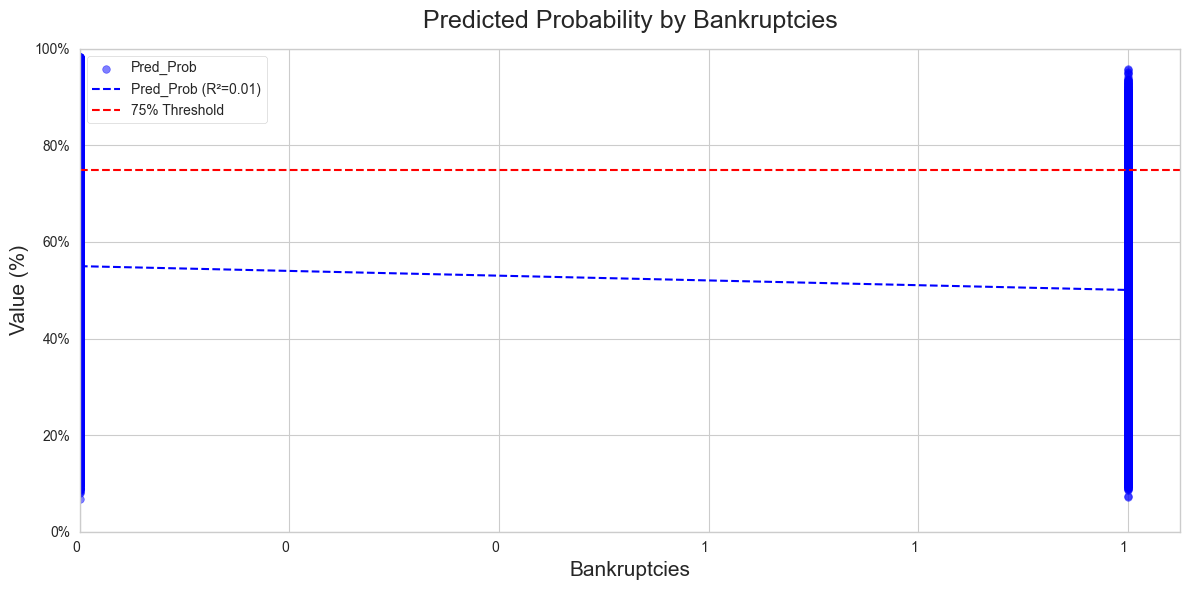

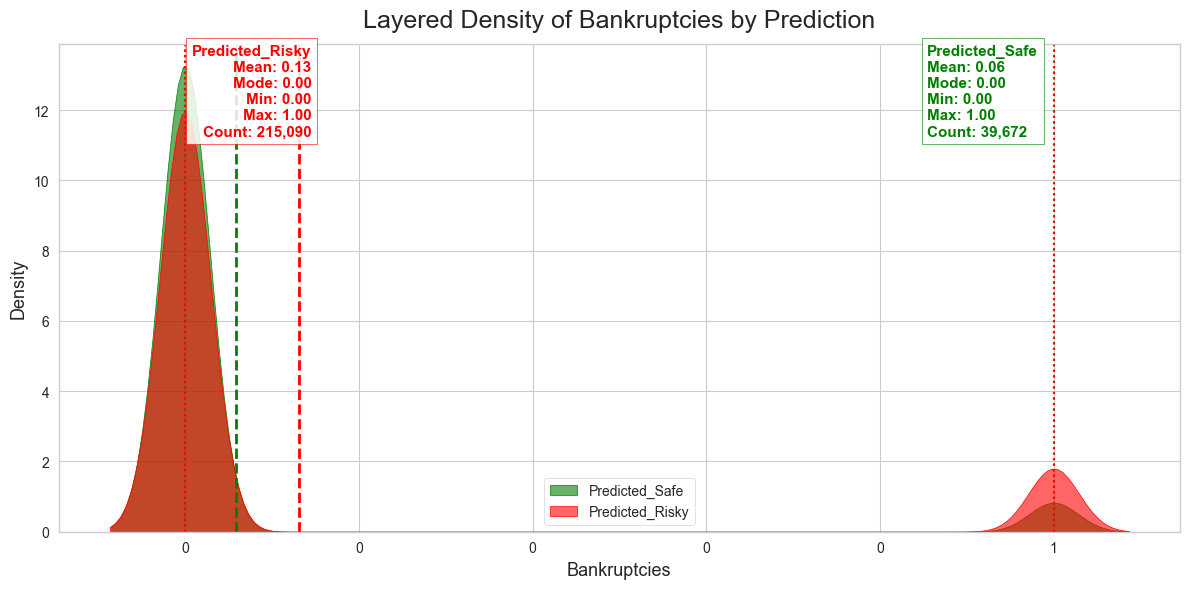

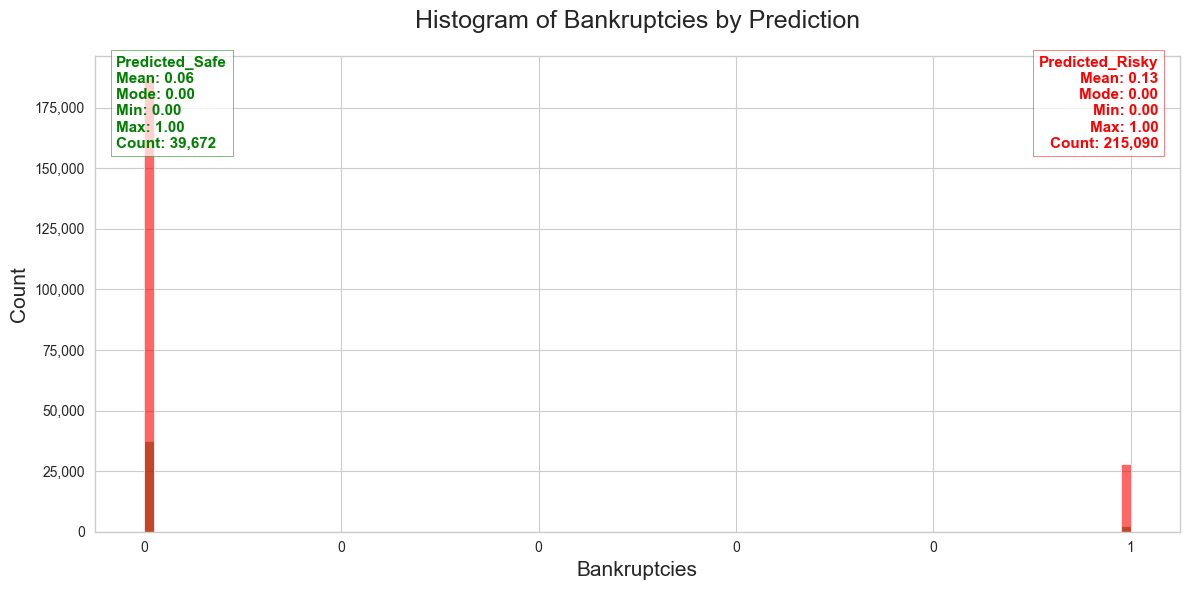

In [79]:
Prob_scatter_plot_reg('Bankruptcies', xformat='number', trim_max=None)
stacked_density_with_stats_boxes('Bankruptcies', xformat='number', trim_max=None)
stacked_hist_acceptance('Bankruptcies', xformat='number', trim_max=None)